## Bank Note Authentication Analysis

## Problem Statement

**Whenever we go to the bank to deposit some cash money, the cashier places banknotes in a machine which tells whether a banknote is real or not. This is a classification problem where we are given some input data and we have to classify the input into one of the several predefined categories. Rule-based as well as statistical techniques are commonly used for solving classification problems. Machine learning algorithms fall in the category of statistical techniques.**

**In this notebook, will explain the process of building a banknote authentication system using machine learning algorithms. After reading this article, you will be able to understand how classification systems are built using machine learning algorithms.**

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

pd.options.display.max_columns = None

pd.options.display.max_rows = None
 
pd.options.display.float_format = '{:.6f}'.format

from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler 

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier


In [91]:
plt.rcParams['figure.figsize'] = [15,8]

<a id="prep"></a>
# Data Preparation

In [92]:
df = pd.read_csv('BankNote_Authentication.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.621600,8.666100,-2.807300,-0.446990,0
1,4.545900,8.167400,-2.458600,-1.462100,0
2,3.866000,-2.638300,1.924200,0.106450,0
3,3.456600,9.522800,-4.011200,-3.594400,0
4,0.329240,-4.455200,4.571800,-0.988800,0


In [5]:
df.shape

(1372, 5)

In [6]:
df.dtypes

variance    float64
skewness    float64
curtosis    float64
entropy     float64
class         int64
dtype: object

In [7]:
Total = df.isnull().sum().sort_values(ascending=False)          


Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   


missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
class,0,0.000000
entropy,0,0.000000
curtosis,0,0.000000
skewness,0,0.000000
variance,0,0.000000


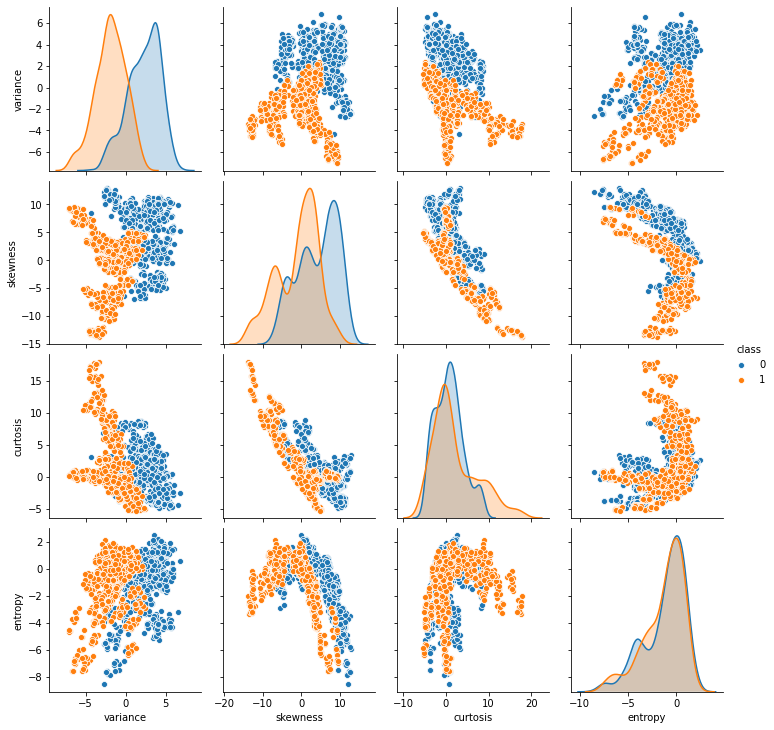

In [8]:
sns.pairplot(df,hue='class');


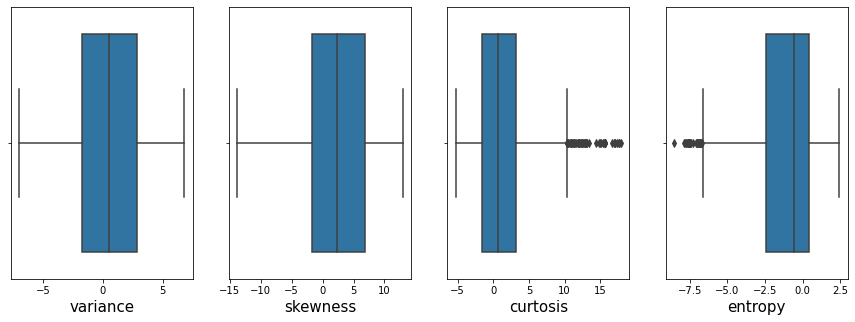

In [9]:
fig,ax =  plt.subplots(1,4, figsize=(15,5))

for variable, subplot in zip(df.columns,ax.flatten()):
    z = sns.boxplot(x=df[variable],orient = 'h',whis=1.5, ax = subplot)
    z.set_xlabel(variable,fontsize =15)

In [10]:
Q1 = df.quantile(0.25) 
Q3 = df.quantile(0.75)
IQR = Q3-Q1
print(IQR)

variance   4.594475
skewness   8.522825
curtosis   4.754225
entropy    2.808260
class      1.000000
dtype: float64


In [11]:
df = df[~((df<(Q1-1.5*IQR))| (df>(Q3+1.5*IQR))).any(axis=1)]

In [93]:
df.shape

(1372, 5)

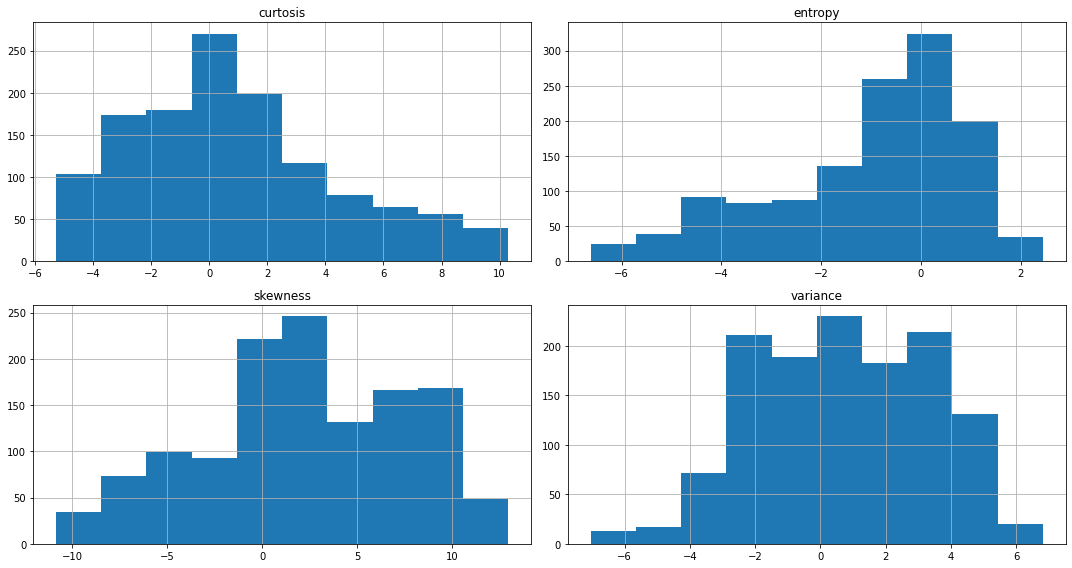

Skewness:


variance   -0.161637
skewness   -0.240673
curtosis    0.586147
entropy    -0.854200
dtype: float64

In [13]:
df.drop('class', axis = 1).hist()

plt.tight_layout()

plt.show()  

print('Skewness:')

df.drop('class', axis = 1).skew()

In [136]:
df_target.value_counts()

0    744
1    536
Name: class, dtype: int64

In [ ]:
df_target = df['class'].copy()

df_target.value_counts()

plt.figure(figsize=(10, 10))
plt.pie(df_target.value_counts(), labels=["GENUINE", "FORGED"], autopct='%.2f%%', colors=['cornflowerblue', 'lightcoral'])
plt.title("Class Distribution")
plt.show()


In [21]:
df_target = df['class']

df_feature = df.drop('class', axis = 1)

In [22]:
df_num = df_feature.select_dtypes(include = [np.number])

df_num.columns

Index(['variance', 'skewness', 'curtosis', 'entropy'], dtype='object')

In [23]:
X_scaler = StandardScaler()


num_scaled = X_scaler.fit_transform(df_num)


df_num_scaled = pd.DataFrame(num_scaled, columns = df_num.columns)

df_num_scaled.head()

,variance,skewness,curtosis,entropy
0,1.078830,1.203411,-1.037471,0.300102
1,1.423723,1.109521,-0.939924,-0.229093
2,1.170026,-0.924867,0.286139,0.588621
3,1.017262,1.364702,-1.374255,-1.340700
4,-0.149680,-1.266935,1.026790,0.017647


In [24]:
X = df.drop('class',axis=1)

y = df_target

In [25]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, df_target, random_state = 10, test_size = 0.2)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (1024, 5)
y_train (1024,)
X_test (256, 5)
y_test (256,)


In [26]:
score_card = pd.DataFrame(columns=['Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score']) 
def update_score_card(model, cutoff):
    
    y_pred_prob = model.predict(X_test)

    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    
    global score_card
    score_card = score_card.append({'Probability Cutoff': cutoff,
                                    'AUC Score' : metrics.roc_auc_score(y_test, y_pred),
                                    'Precision Score': metrics.precision_score(y_test, y_pred),
                                    'Recall Score': metrics.recall_score(y_test, y_pred),
                                    'Accuracy Score': metrics.accuracy_score(y_test, y_pred),
                                    'Kappa Score':metrics.cohen_kappa_score(y_test, y_pred),
                                    'f1-score': metrics.f1_score(y_test, y_pred)}, 
                                    ignore_index = True)

# 3. Logistic Regression (Full Model)


In [27]:
logreg = sm.Logit(y_train, X_train).fit()

print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.006402
         Iterations 18
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1024
Model:                          Logit   Df Residuals:                     1019
Method:                           MLE   Df Model:                            4
Date:                Tue, 15 Jun 2021   Pseudo R-squ.:                  0.9906
Time:                        16:30:31   Log-Likelihood:                -6.5552
converged:                       True   LL-Null:                       -694.58
Covariance Type:            nonrobust   LLR p-value:                1.076e-296
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5681     14.800      1.525      0.127      -6.440      51.576
variance     -23.9905     17

In [28]:
print('AIC:', logreg.aic)

AIC: 23.110443478513616


### Interpret the odds for each variable 

In [29]:
df_odds = pd.DataFrame(np.exp(logreg.params), columns= ['Odds']) 

df_odds

,Odds
const,6326949079.176592
variance,0.000000
skewness,0.000003
curtosis,0.000000
entropy,0.196387


In [30]:
y_pred_prob = logreg.predict(X_test)

y_pred_prob.head()

909    1.000000
674    0.000000
929    1.000000
460    0.000000
1258   1.000000
dtype: float64

In [31]:
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]

In [32]:
y_pred[0:5]

[1, 0, 1, 0, 1]

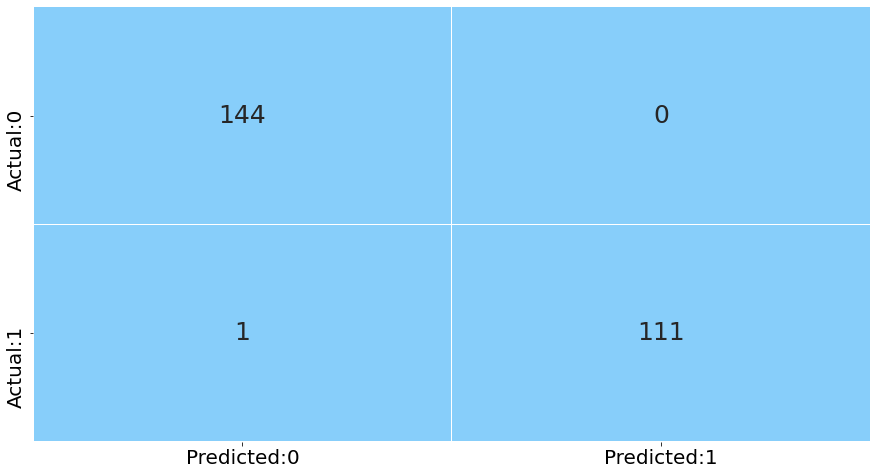

In [33]:
cm = confusion_matrix(y_test, y_pred)


conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)

plt.yticks(fontsize = 20)

plt.show()

In [34]:
TN = cm[0,0]


TP = cm[1,1]


FP = cm[0,1]


FN = cm[1,0]

In [35]:
precision = TP / (TP+FP)

precision

1.0

In [36]:
recall = TP / (TP+FN)

recall

0.9910714285714286

In [37]:
specificity = TN / (TN+FP)

specificity

1.0

In [38]:
f1_score = 2*((precision*recall)/(precision+recall))

f1_score

0.9955156950672646

In [39]:
accuracy = (TN+TP) / (TN+FP+FN+TP)

accuracy

0.99609375

In [40]:
acc_table = classification_report(y_test, y_pred)

print(acc_table)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       144
           1       1.00      0.99      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



In [41]:
kappa = cohen_kappa_score(y_test, y_pred)

print('kappa value:',kappa)

kappa value: 0.9920556107249255


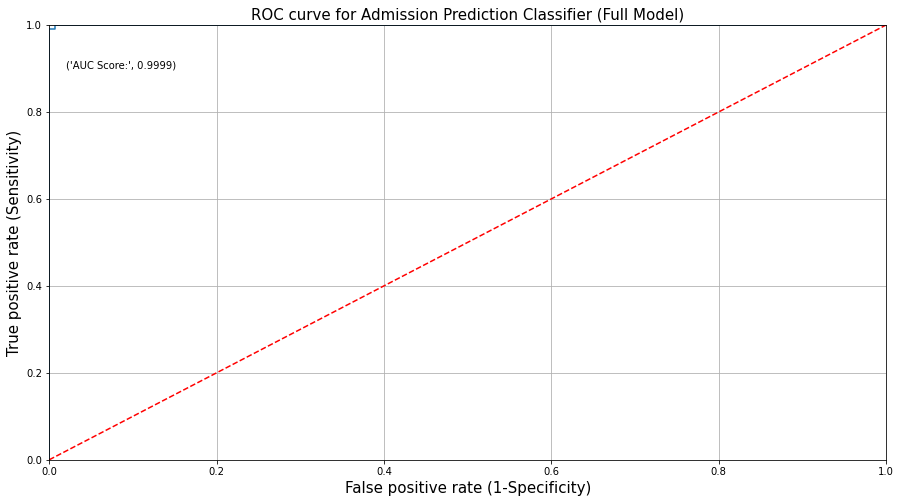

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot([0, 1], [0, 1],'r--')


plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)


plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob),4)))
                               
plt.grid(True)

<a id="cut_off"></a>
##  Identify the Best Cut-off Value

In [43]:
cutoff = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for value in cutoff:
    update_score_card(logreg, value)

In [44]:
print('Score Card for Logistic regression:')

score_card = score_card.sort_values('Probability Cutoff').reset_index(drop = True)

score_card.style.highlight_max(color = 'lightblue', subset = ['AUC Score', 'Accuracy Score', 'Kappa Score', 'f1-score'])

Score Card for Logistic regression:


,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,0.100000,0.992063,0.991071,0.991071,0.992188,0.984127,0.991071
1,0.200000,0.992063,0.991071,0.991071,0.992188,0.984127,0.991071
2,0.300000,0.992063,0.991071,0.991071,0.992188,0.984127,0.991071
3,0.400000,0.992063,0.991071,0.991071,0.992188,0.984127,0.991071
4,0.500000,0.995536,1.000000,0.991071,0.996094,0.992056,0.995516
5,0.600000,0.995536,1.000000,0.991071,0.996094,0.992056,0.995516
6,0.700000,0.995536,1.000000,0.991071,0.996094,0.992056,0.995516
7,0.800000,0.995536,1.000000,0.991071,0.996094,0.992056,0.995516
8,0.900000,0.995536,1.000000,0.991071,0.996094,0.992056,0.995516


<a id="youden"></a>
### Youden's Index

In [45]:
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})

youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR


youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)

youdens_table.head()

,TPR,FPR,Threshold,Difference
0,1.000000,0.006944,0.006384,0.993056
1,0.991071,0.000000,0.901836,0.991071
2,0.991071,0.006944,0.450573,0.984127
3,0.750000,0.000000,1.000000,0.750000
4,0.696429,0.000000,1.000000,0.696429


In [46]:
y_pred_youden = [ 0 if x < 0.62 else 1 for x in y_pred_prob]

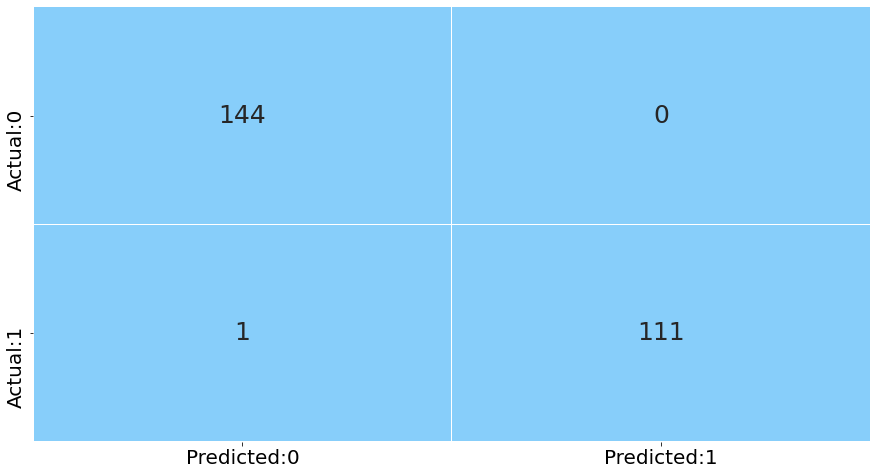

In [47]:
cm = confusion_matrix(y_test, y_pred_youden)


conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])


sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)

plt.yticks(fontsize = 20)

plt.show()

In [48]:
acc_table = classification_report(y_test, y_pred_youden)

print(acc_table)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       144
           1       1.00      0.99      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



In [49]:
kappa = cohen_kappa_score(y_test, y_pred_youden)

print('kappa value:',kappa)

kappa value: 0.9920556107249255


<a id="cost"></a>
###  Cost-based Method

In [50]:
def calculate_total_cost(actual_value, predicted_value, cost_FN, cost_FP):

    cm = confusion_matrix(actual_value, predicted_value)           
    
    cm_array = np.array(cm)
    
    return cm_array[1,0] * cost_FN + cm_array[0,1] * cost_FP

df_total_cost = pd.DataFrame(columns = ['cut-off', 'total_cost'])

i = 0

for cut_off in range(10, 100):
    total_cost = calculate_total_cost(y_test,  y_pred_prob.map(lambda x: 1 if x > (cut_off/100) else 0), 3.5, 2) 
    df_total_cost.loc[i] = [(cut_off/100), total_cost] 
    
    i += 1

In [51]:
df_total_cost.sort_values('total_cost', ascending = True).head(10)

,cut-off,total_cost
44,0.540000,3.500000
57,0.670000,3.500000
56,0.660000,3.500000
55,0.650000,3.500000
54,0.640000,3.500000
53,0.630000,3.500000
52,0.620000,3.500000
51,0.610000,3.500000
50,0.600000,3.500000
49,0.590000,3.500000


In [52]:
y_pred_cost = [ 0 if x < 0.58 else 1 for x in y_pred_prob]

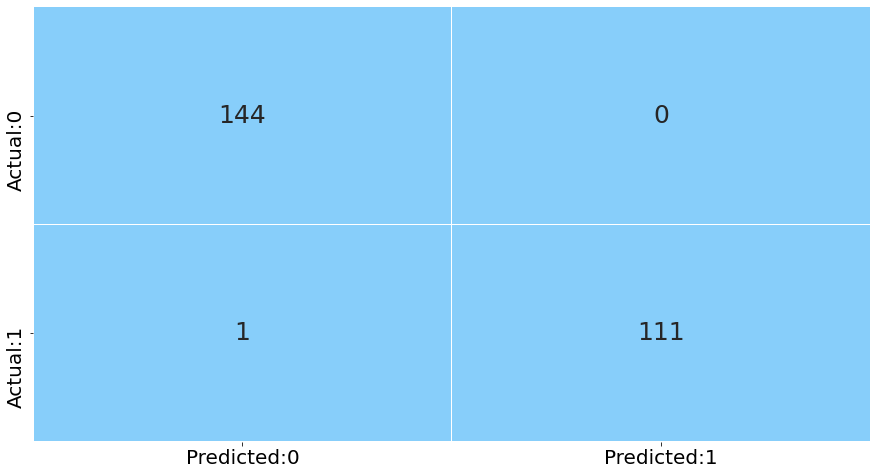

In [53]:
cm = confusion_matrix(y_test, y_pred_cost)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)

plt.yticks(fontsize = 20)

plt.show()

In [54]:
acc_table = classification_report(y_test, y_pred_cost)

print(acc_table)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       144
           1       1.00      0.99      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



In [55]:
kappa = cohen_kappa_score(y_test, y_pred_cost)

print('kappa value:',kappa)

kappa value: 0.9920556107249255


<a id="rfe"></a>
#  Recursive Feature Elimination (RFE)

In [119]:

X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]

logreg = LogisticRegression()
rfe_model = RFE(estimator = logreg, n_features_to_select = 3)

rfe_model = rfe_model.fit(X_train_rfe, y_train)


feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)

signi_feat_rfe = feat_index[feat_index==1].index

print(signi_feat_rfe)

Index(['variance', 'skewness', 'curtosis'], dtype='object')


In [121]:
logreg_rfe = sm.Logit(y_train, X_train[['const', 'variance', 'skewness', 'curtosis']]).fit()

print(logreg_rfe.summary())

Optimization terminated successfully.
         Current function value: 0.006576
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1024
Model:                          Logit   Df Residuals:                     1020
Method:                           MLE   Df Model:                            3
Date:                Tue, 15 Jun 2021   Pseudo R-squ.:                  0.9903
Time:                        18:07:37   Log-Likelihood:                -6.7333
converged:                       True   LL-Null:                       -694.58
Covariance Type:            nonrobust   LLR p-value:                5.527e-298
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7305     10.588      1.864      0.062      -1.021      40.482
variance     -18.8703     10

In [122]:
print('AIC:', logreg_rfe.aic)

AIC: 21.4666367926532


In [124]:
y_pred_prob_rfe = logreg_rfe.predict(X_test[['const', 'variance', 'skewness', 'curtosis']])

# print the y_pred_prob_rfe
y_pred_prob_rfe.head()

909    1.000000
674    0.000000
929    1.000000
460    0.000000
1258   1.000000
dtype: float64

In [125]:
y_pred_rfe = [ 0 if x < 0.6 else 1 for x in y_pred_prob_rfe]

In [126]:
y_pred_rfe[0:5]

[1, 0, 1, 0, 1]

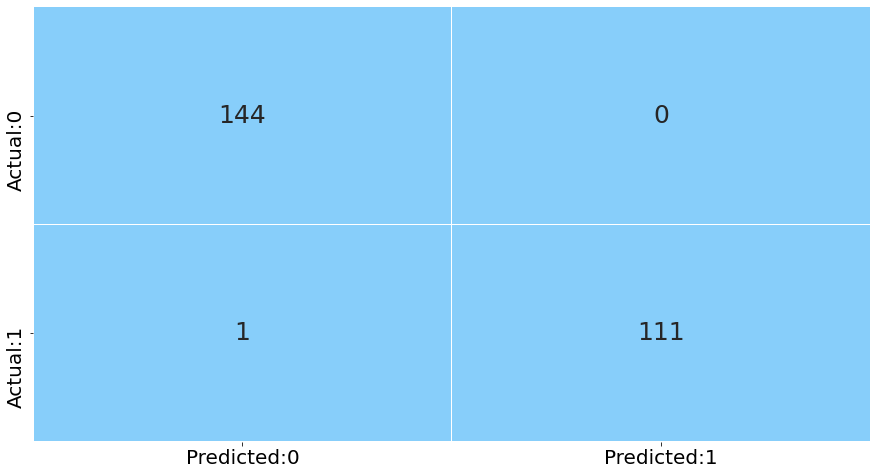

In [127]:
cm = confusion_matrix(y_test, y_pred_rfe)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)

plt.yticks(fontsize = 20)

plt.show()

In [128]:
result = classification_report(y_test, y_pred_rfe)

print(result)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       144
           1       1.00      0.99      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



In [129]:
kappa = cohen_kappa_score(y_test, y_pred_rfe)

print('kappa value:',kappa)

kappa value: 0.9920556107249255


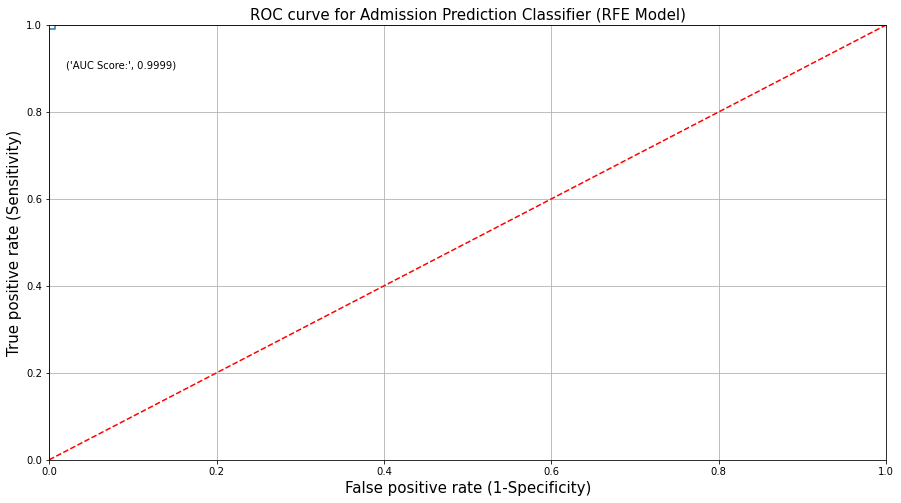

In [130]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rfe)

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot([0, 1], [0, 1],'r--')

plt.title('ROC curve for Admission Prediction Classifier (RFE Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob_rfe),4)))
                               
plt.grid(True)

# Naive Bayes Algorithm

In [117]:
def get_test_report(model):

    test_pred = model.predict(X_test)

    return(classification_report(y_test, test_pred))

In [118]:
def plot_confusion_matrix(model):
    
    y_pred = model.predict(X_test)
    
   
    cm = confusion_matrix(y_test, y_pred)

    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

    
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})

    plt.xticks(fontsize = 20)

    plt.yticks(fontsize = 20)

    plt.show()

In [58]:
def plot_roc(model):
      
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    plt.plot(fpr, tpr)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.plot([0, 1], [0, 1],'r--')


    plt.title('ROC curve for Cancer Prediction Classifier', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

 
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    plt.grid(True)

In [59]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb_model = gnb.fit(X_train, y_train)

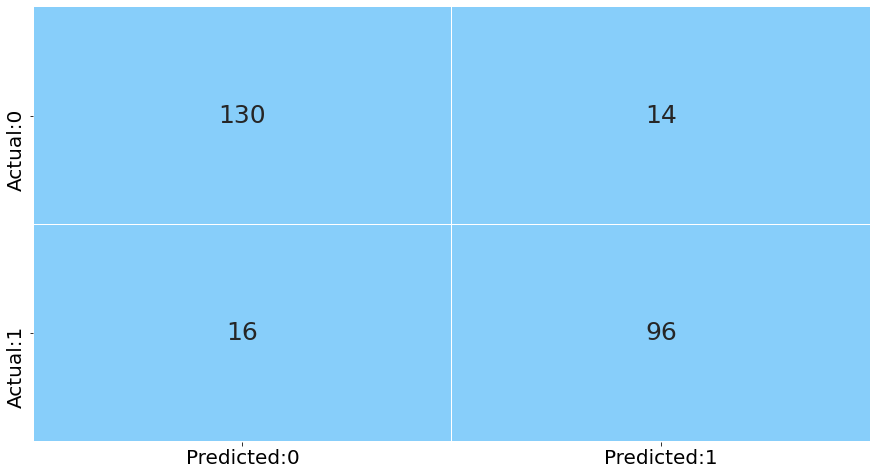

In [60]:
plot_confusion_matrix(gnb_model)

In [61]:
test_report = get_test_report(gnb_model)

print(test_report)

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       144
           1       0.87      0.86      0.86       112

    accuracy                           0.88       256
   macro avg       0.88      0.88      0.88       256
weighted avg       0.88      0.88      0.88       256



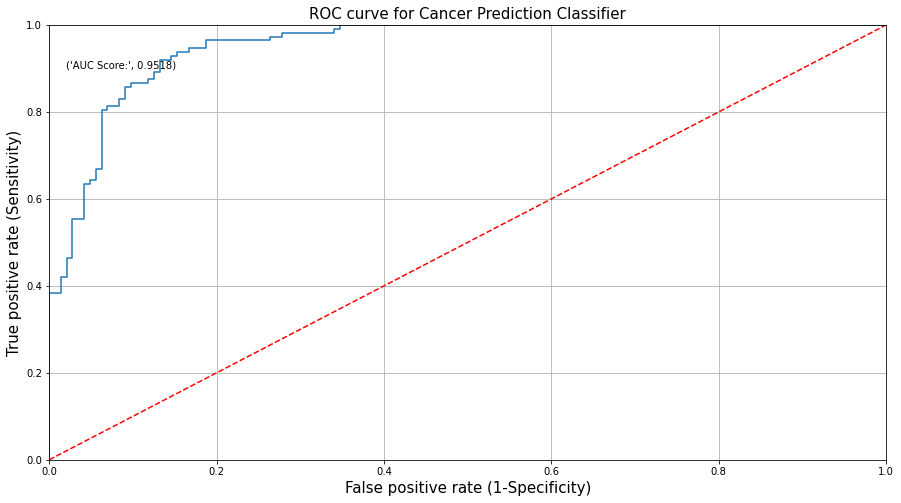

In [62]:
plot_roc(gnb_model)

#  K Nearest Neighbors (KNN)

In [63]:
knn_classification = KNeighborsClassifier(n_neighbors = 3)

knn_model = knn_classification.fit(X_train, y_train)

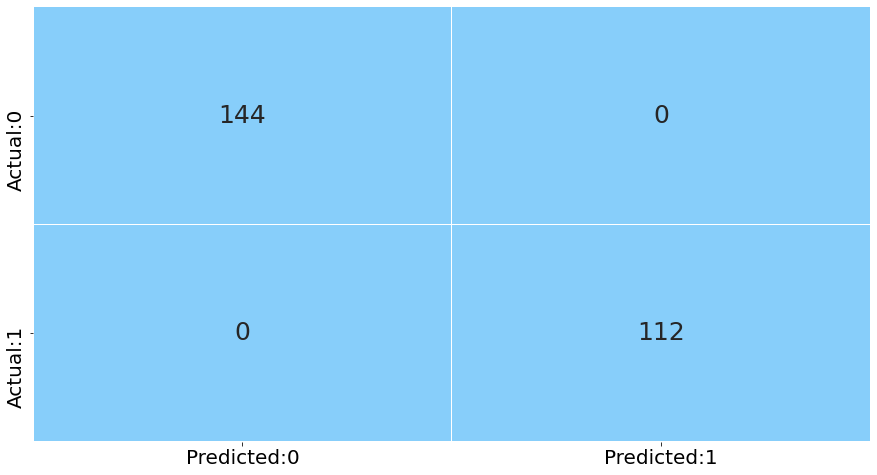

In [64]:
plot_confusion_matrix(knn_model)

In [65]:
test_report = get_test_report(knn_model)

print(test_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



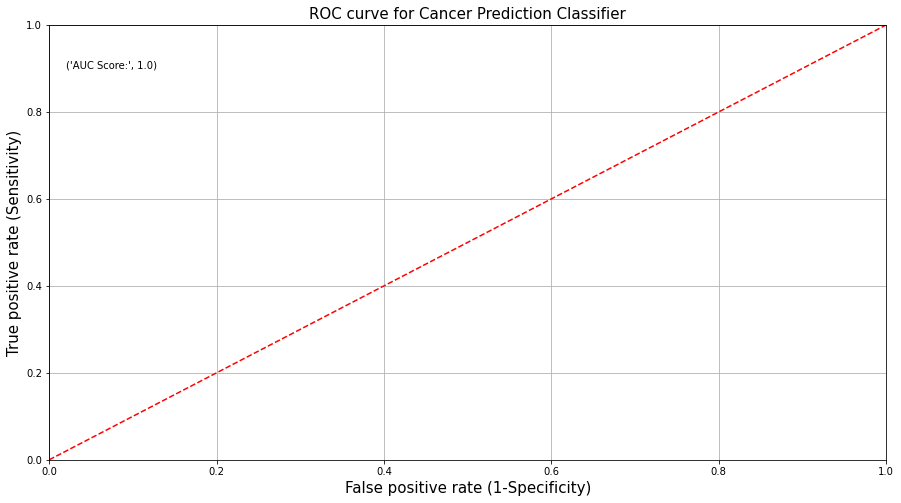

In [66]:
plot_roc(knn_model)

##  Optimal Value of K (using GridSearchCV)


In [67]:
tuned_paramaters = {'n_neighbors': np.arange(1, 25, 2),
                   'metric': ['hamming','euclidean','manhattan','Chebyshev']}
 
knn_classification = KNeighborsClassifier()

knn_grid = GridSearchCV(estimator = knn_classification, 
                        param_grid = tuned_paramaters, 
                        cv = 5, 
                        scoring = 'accuracy')

knn_grid.fit(X_train, y_train)

print('Best parameters for KNN Classifier: ', knn_grid.best_params_, '\n')

Best parameters for KNN Classifier:  {'metric': 'euclidean', 'n_neighbors': 3} 



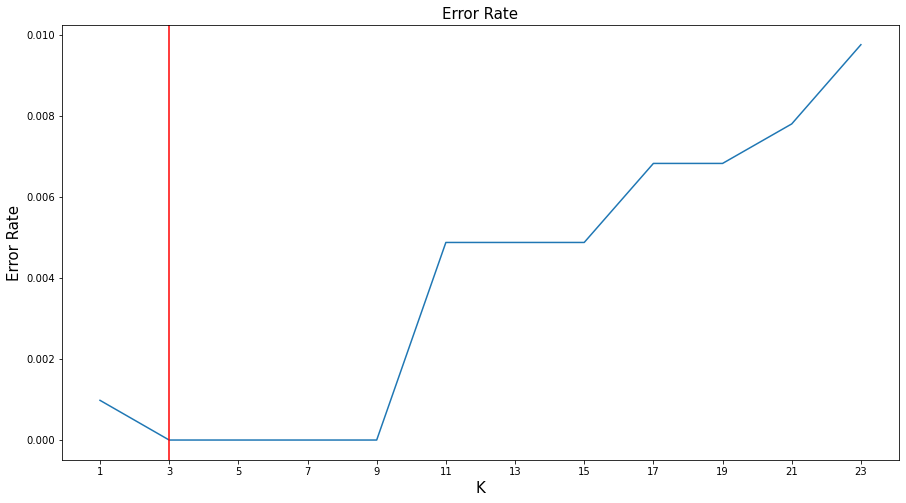

In [68]:
error_rate = []

for i in np.arange(1,25,2):
 
    knn = KNeighborsClassifier(i, metric = 'euclidean')
   
    score = cross_val_score(knn, X_train, y_train, cv = 5)
    
    score = score.mean()
    
  
    error_rate.append(1 - score)

plt.plot(range(1,25,2), error_rate)


plt.title('Error Rate', fontsize = 15)
plt.xlabel('K', fontsize = 15)
plt.ylabel('Error Rate', fontsize = 15)


plt.xticks(np.arange(1, 25, step = 2))

plt.axvline(x = 3, color = 'red')

plt.show()

In [69]:
print('Classification Report for test set: \n', get_test_report(knn_grid))

Classification Report for test set: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



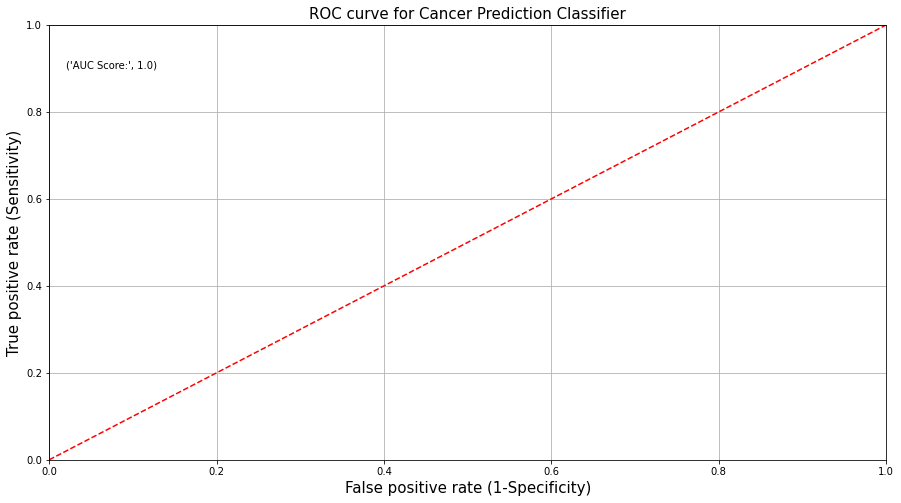

In [70]:
plot_roc(knn_grid)

# Decision Tree for classification

In [71]:
decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)

decision_tree = decision_tree_classification.fit(X_train, y_train)

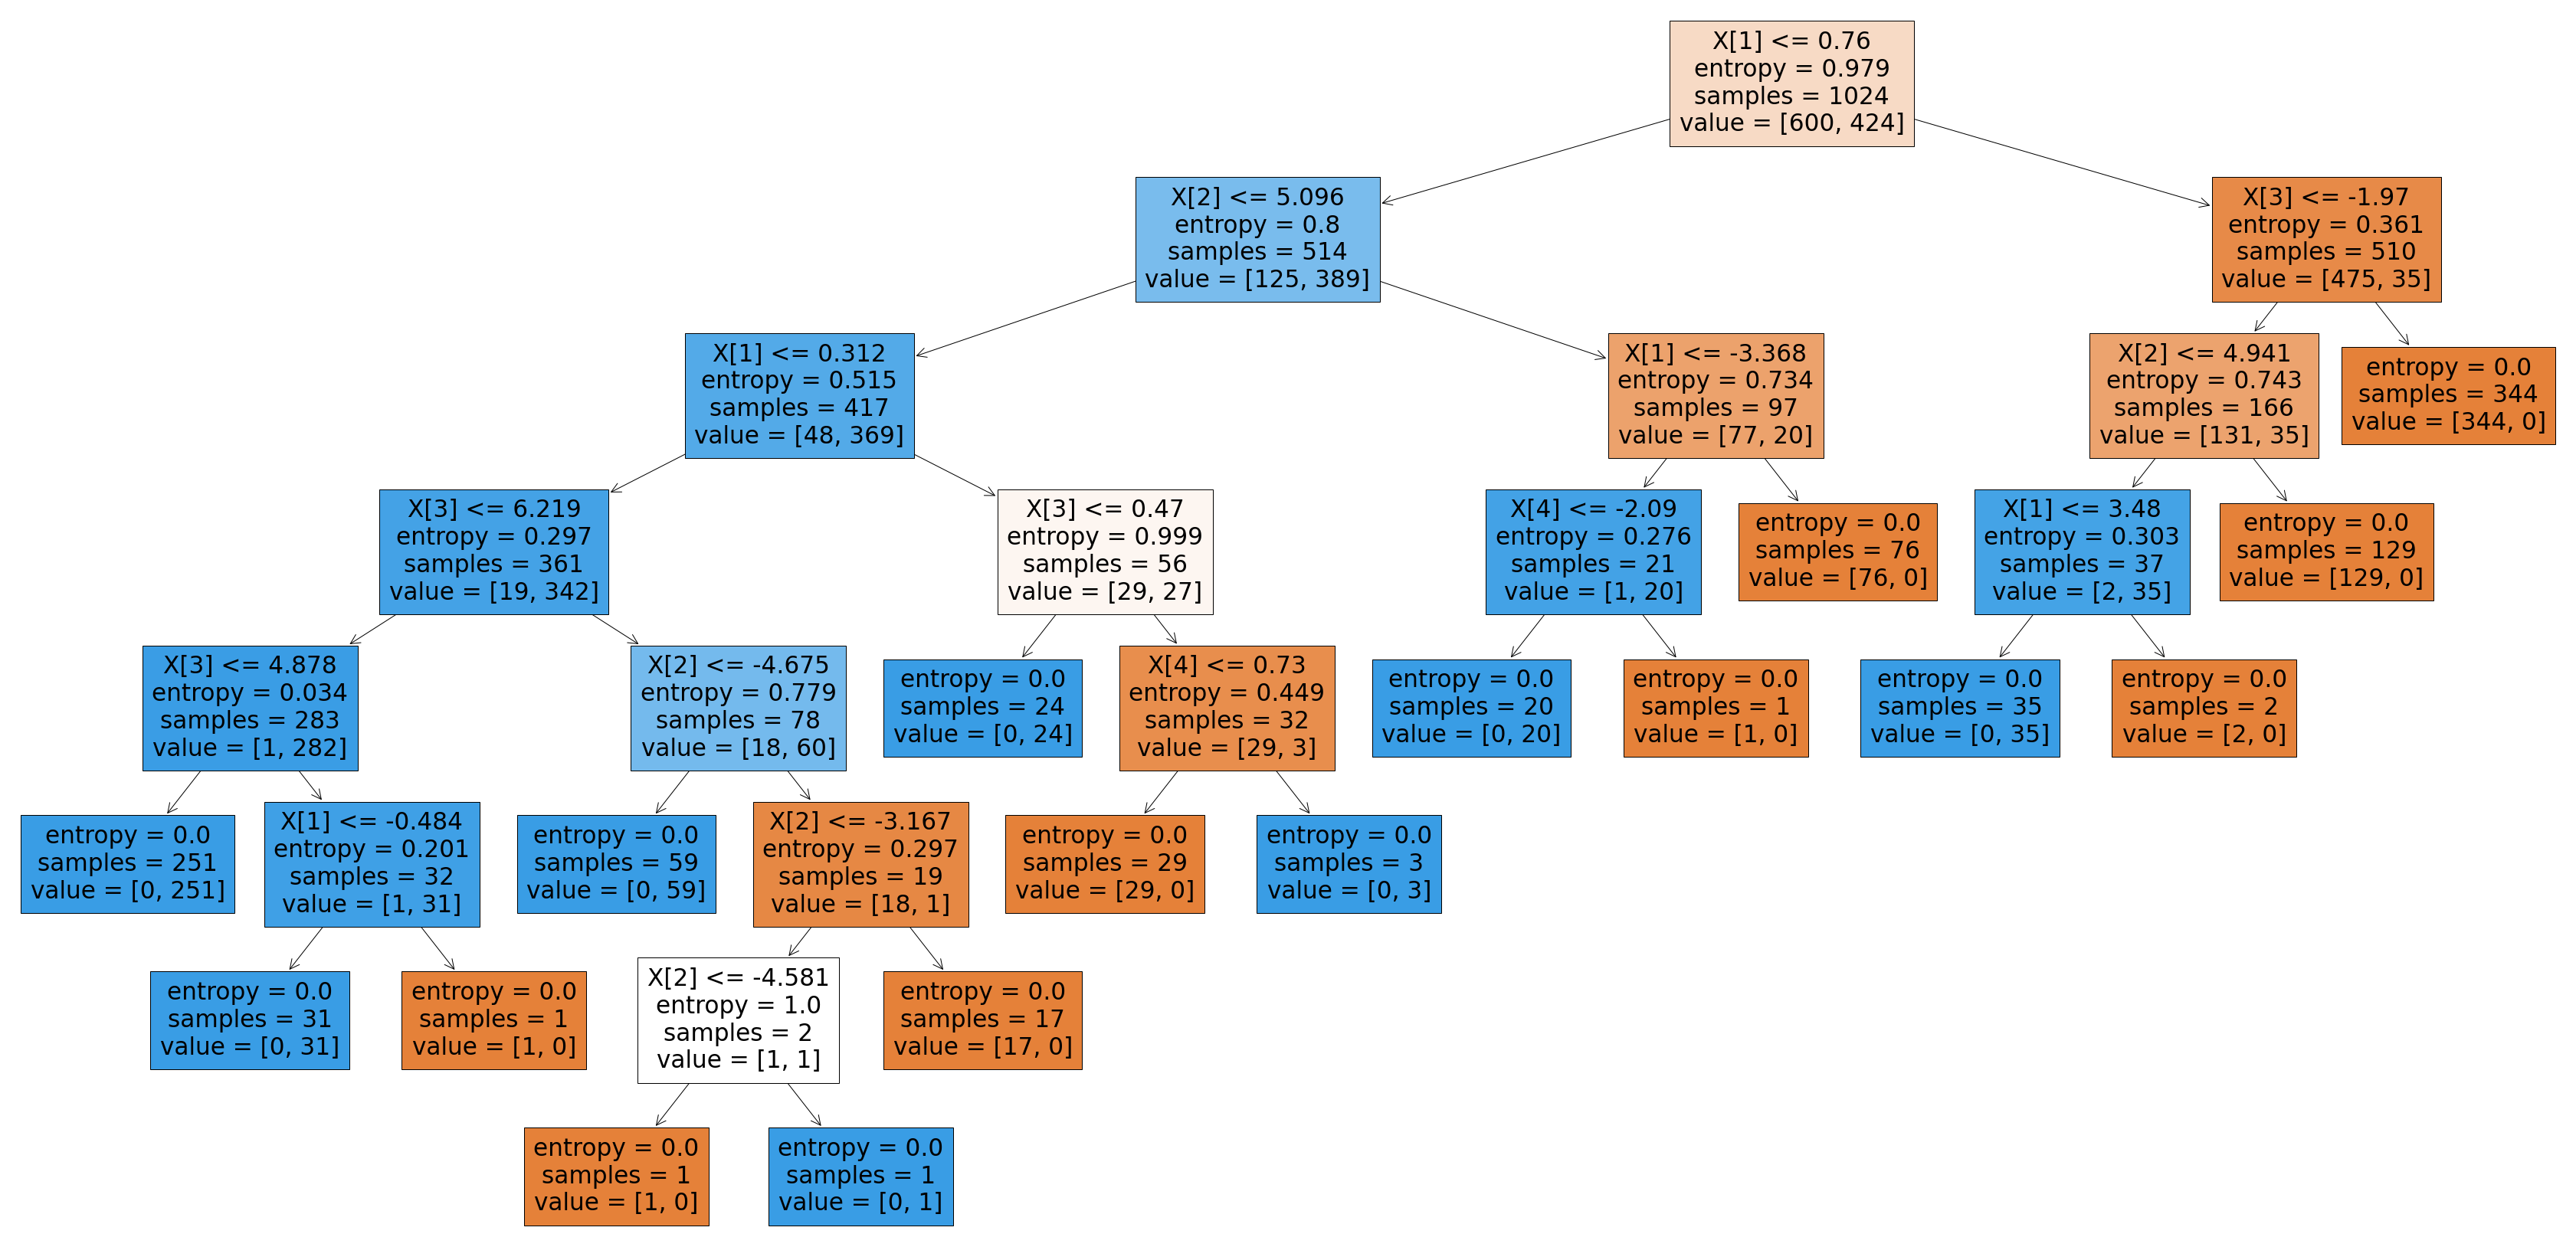

In [72]:
from sklearn.tree import plot_tree
plt.figure(figsize=(60,30))
plot_tree(decision_tree, filled=True);

In [73]:
def get_test_report(model):
    test_pred = model.predict(X_test)
    return(classification_report(y_test, test_pred))

In [74]:
def get_train_report(model):   
    train_pred = model.predict(X_train)
    return(classification_report(y_train, train_pred))

## Over-fitting in Decision Tree

The decision tree is said to be over-fitted if it tries to perfectly fit all the observations in the training data. We can calculate the difference between the train and test accuracy to identify if there is over-fitting.

In [75]:
train_report = get_train_report(decision_tree)

print(train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       424

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [76]:
test_report = get_test_report(decision_tree)

print(test_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       144
           1       0.98      0.98      0.98       112

    accuracy                           0.98       256
   macro avg       0.98      0.98      0.98       256
weighted avg       0.98      0.98      0.98       256



## Tune the Hyperparameters using GridSearchCV (Decision Tree)


In [77]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'], 
                     'max_depth': range(2, 5),
                     'max_features': ["sqrt", "log2"],
                     'min_samples_split': range(2,5),
                     'min_samples_leaf': range(1,10),
                     'max_leaf_nodes': range(1, 10)}]
 
decision_tree_classification = DecisionTreeClassifier(random_state = 10)


tree_grid = GridSearchCV(estimator = decision_tree_classification, 
                         param_grid = tuned_paramaters, 
                         cv = 5)

tree_grid_model = tree_grid.fit(X_train, y_train)

print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifier:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'min_samples_split': 2} 



In [78]:
dt_model = DecisionTreeClassifier(criterion = tree_grid_model.best_params_.get('criterion'),
                                  max_depth = tree_grid_model.best_params_.get('max_depth'),
                                  max_features = tree_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = tree_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = tree_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = tree_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

dt_model = dt_model.fit(X_train, y_train)


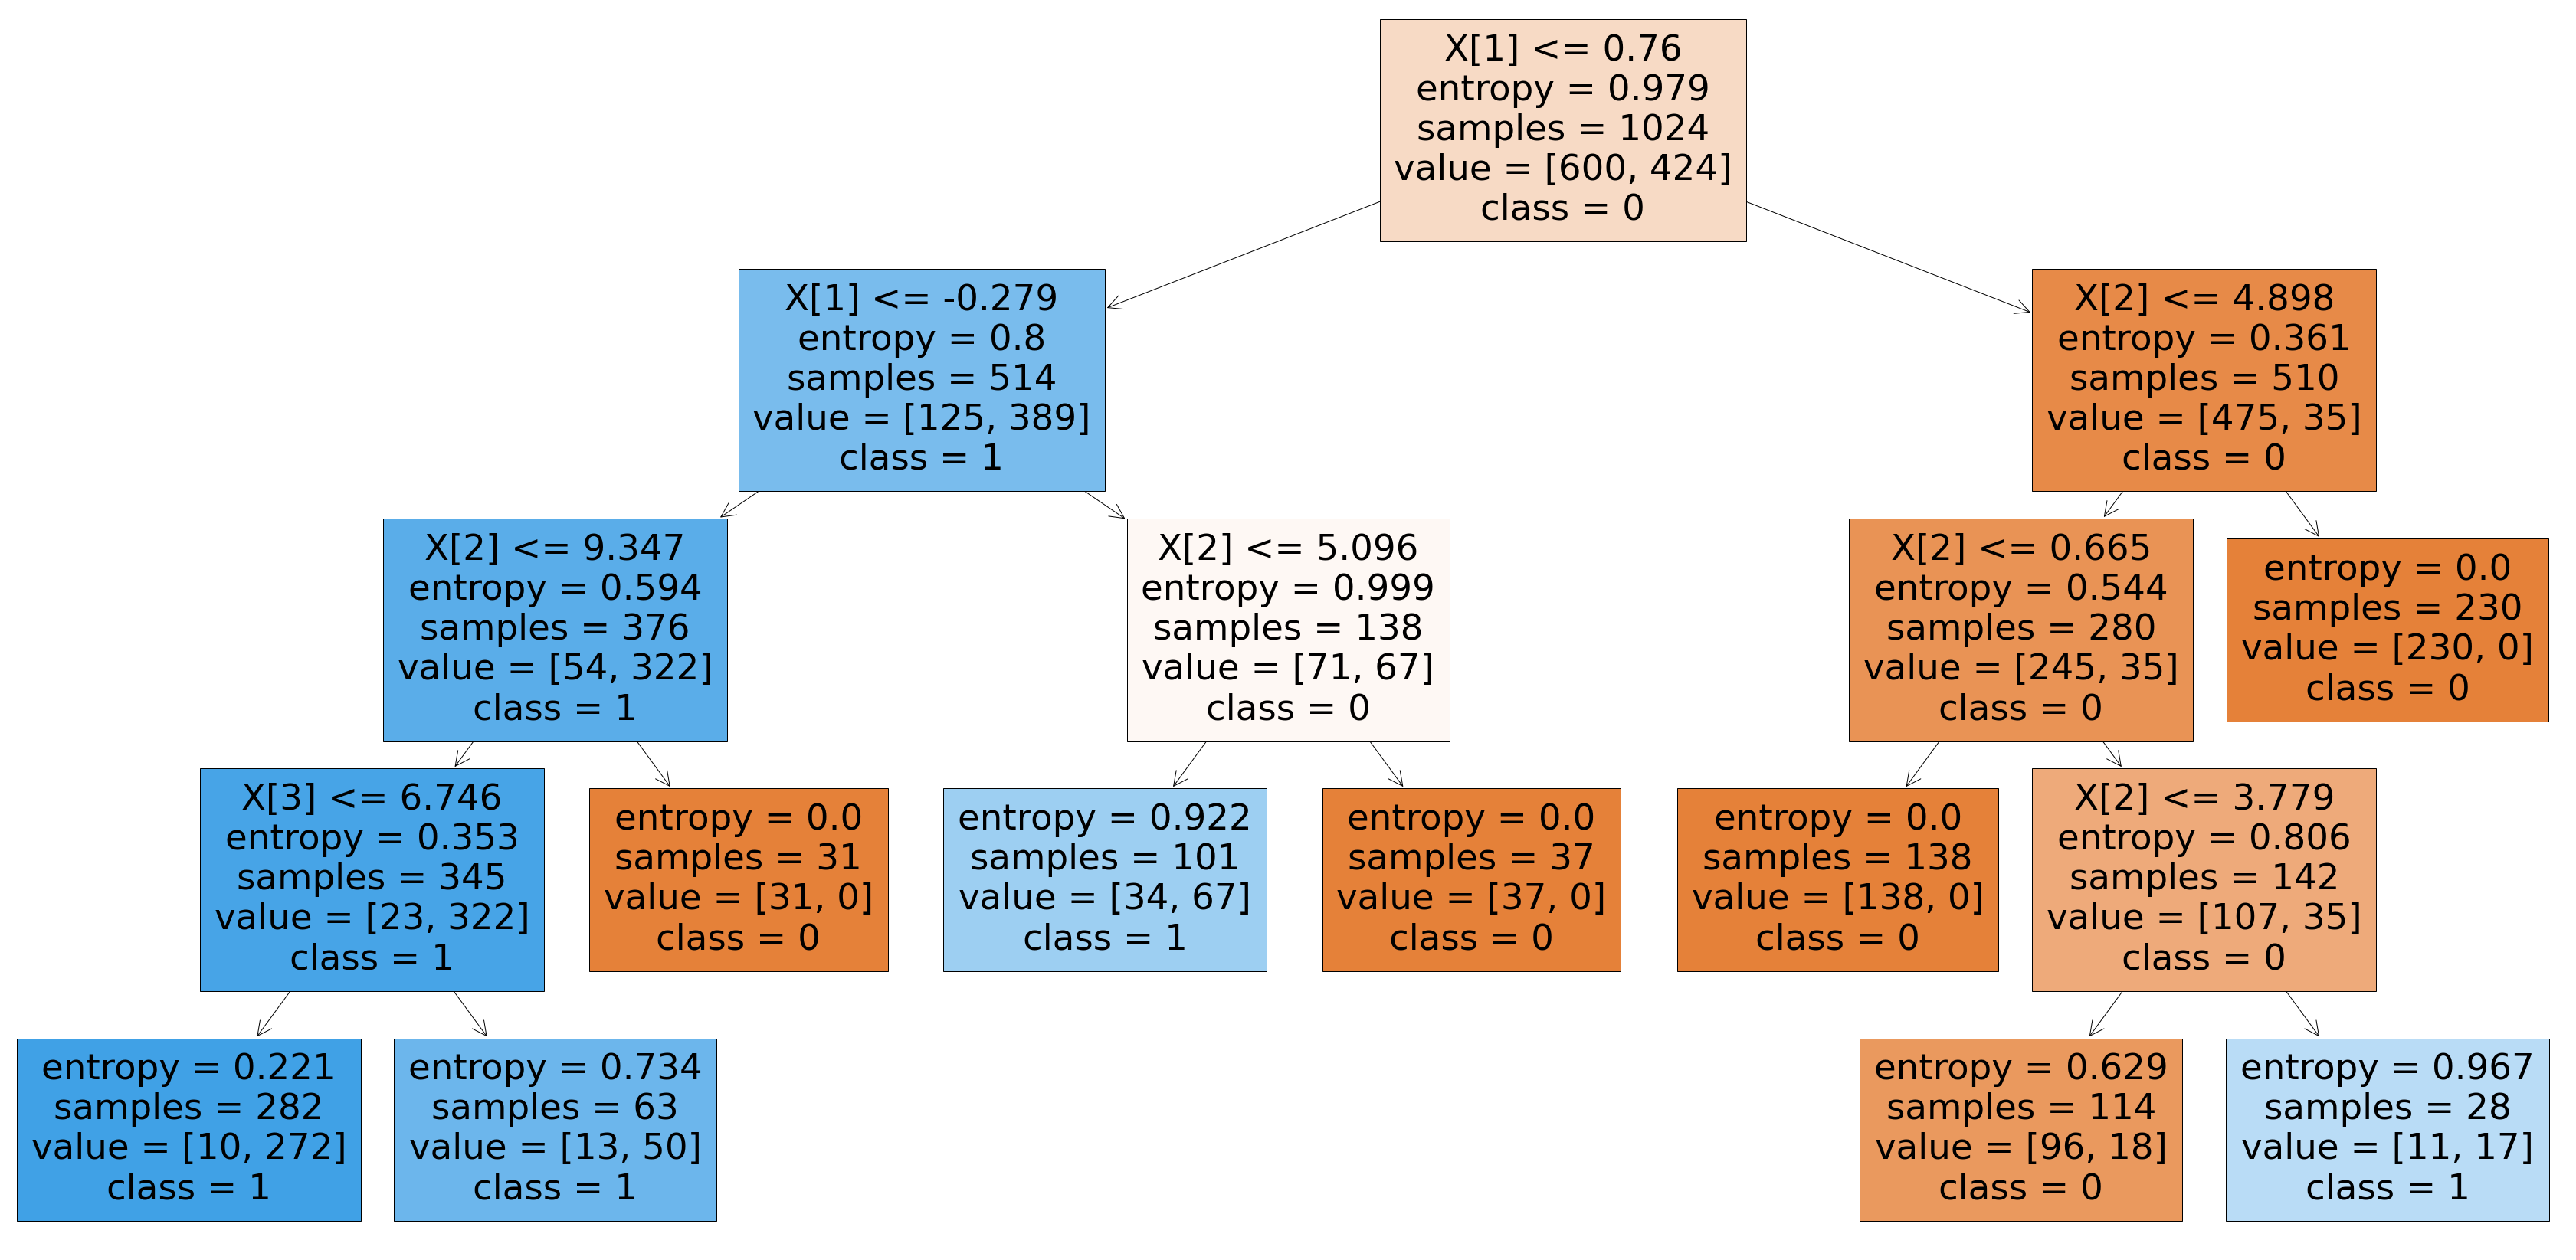

In [79]:
plt.figure(figsize=(60,30))
plot_tree(dt_model, filled=True, class_names = ["0","1"]);

In [80]:
print('Classification Report for train set: \n', get_train_report(dt_model))

Classification Report for train set: 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       600
           1       0.86      0.96      0.90       424

    accuracy                           0.92      1024
   macro avg       0.91      0.92      0.91      1024
weighted avg       0.92      0.92      0.92      1024



In [81]:
print('Classification Report for test set: \n', get_test_report(dt_model))

Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       144
           1       0.88      0.94      0.91       112

    accuracy                           0.92       256
   macro avg       0.92      0.92      0.92       256
weighted avg       0.92      0.92      0.92       256



#  Random Forest for Classification

In [82]:
rf_classification = RandomForestClassifier(n_estimators = 10, random_state = 10)

rf_model = rf_classification.fit(X_train, y_train)

In [83]:
train_report = get_train_report(rf_model)

print(train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       424

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [88]:
test_report = get_test_report(rf_model)

print(test_report) 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       144
           1       0.99      0.98      0.99       112

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



##  Tune the Hyperparameters using GridSearchCV (Random Forest)

In [ ]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]
 

random_forest_classification = RandomForestClassifier(random_state = 10)

rf_grid = GridSearchCV(estimator = random_forest_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 5)

rf_grid_model = rf_grid.fit(X_train, y_train)

print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

In [ ]:
rf_model = RandomForestClassifier(criterion = rf_grid_model.best_params_.get('criterion'), 
                                  n_estimators = rf_grid_model.best_params_.get('n_estimators'),
                                  max_depth = rf_grid_model.best_params_.get('max_depth'),
                                  max_features = rf_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = rf_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = rf_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = rf_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

rf_model = rf_model.fit(X_train, y_train)

print('Classification Report for test set:\n', get_test_report(rf_model))

<a id="boosting"></a>
#  Boosting Methods

<a id="ada"></a>
##  AdaBoost

In [95]:
  
def get_test_report(model):
    
    test_pred = model.predict(X_test)

    return(classification_report(y_test, test_pred))

In [96]:
def plot_confusion_matrix(model):
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
   
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})

    plt.xticks(fontsize = 20)

    plt.yticks(fontsize = 20)

    plt.show()

In [97]:
def plot_roc(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    plt.plot(fpr, tpr)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.plot([0, 1], [0, 1],'r--')
    plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    plt.grid(True)

In [98]:
ada_model = AdaBoostClassifier(n_estimators = 40, random_state = 10)

ada_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=40, random_state=10)

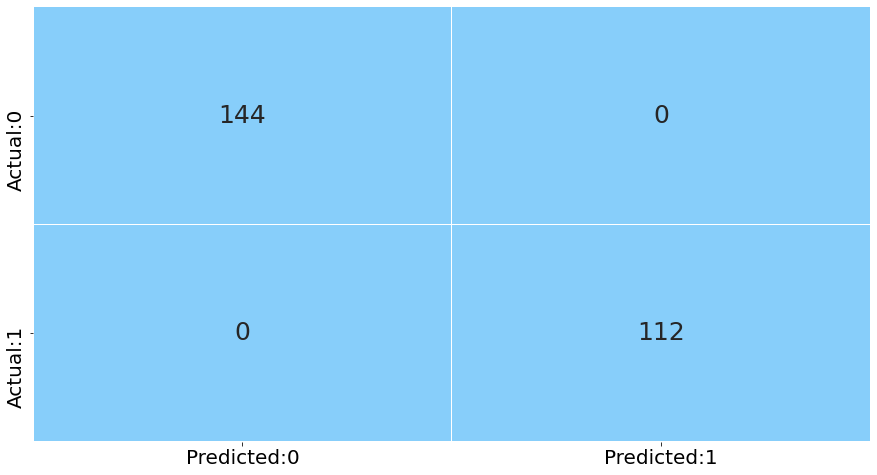

In [99]:
plot_confusion_matrix(ada_model)

In [100]:
test_report = get_test_report(ada_model)
print(test_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



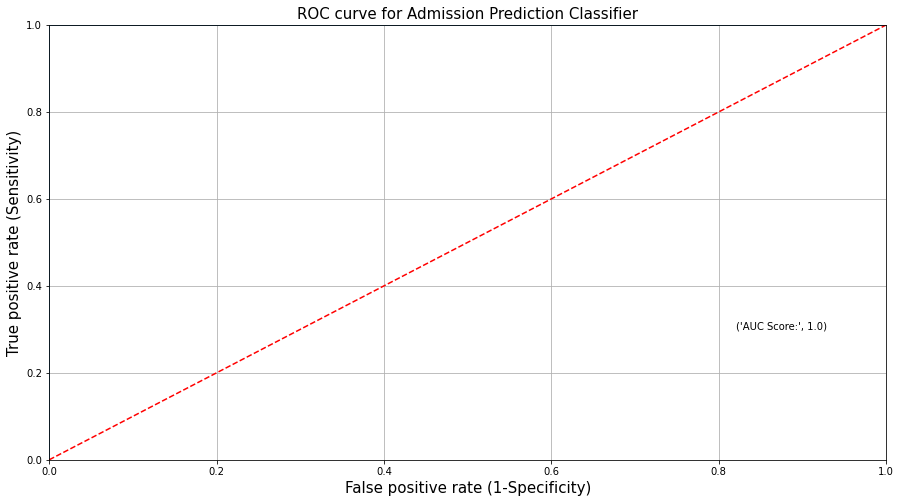

In [101]:
plot_roc(ada_model)

<a id="gradient"></a>
##  Gradient Boosting

In [102]:
gboost_model = GradientBoostingClassifier(n_estimators = 150, max_depth = 10, random_state = 10)

gboost_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=150, random_state=10)

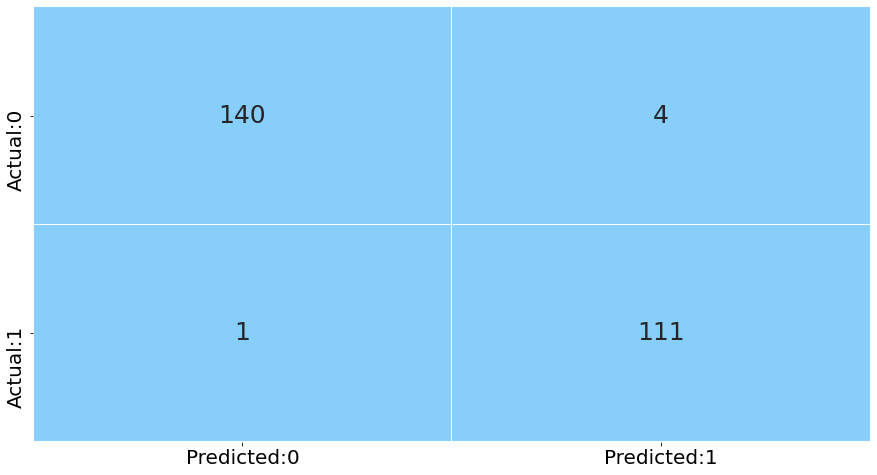

In [103]:
plot_confusion_matrix(gboost_model)

In [104]:
test_report = get_test_report(gboost_model)

print(test_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       144
           1       0.97      0.99      0.98       112

    accuracy                           0.98       256
   macro avg       0.98      0.98      0.98       256
weighted avg       0.98      0.98      0.98       256



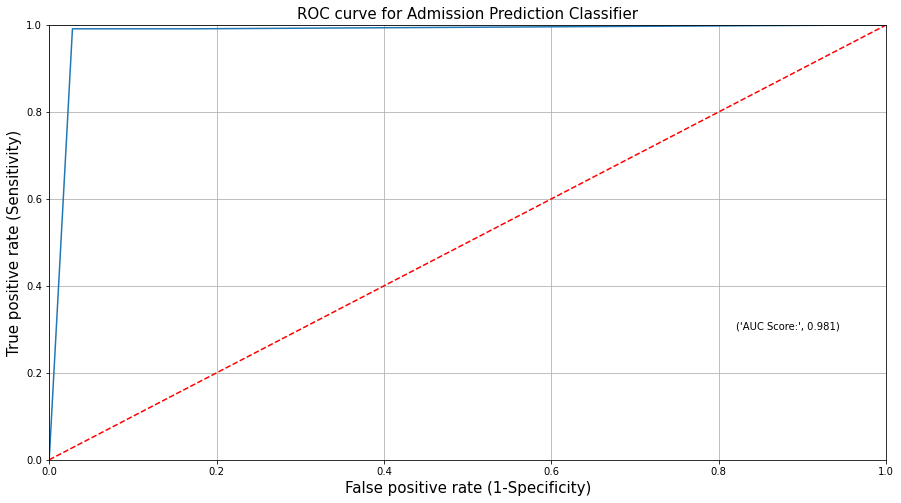

In [105]:
plot_roc(gboost_model)

# XGBoost

In [107]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth = 10, gamma = 1)

xgb_model.fit(X_train, y_train)

[17:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

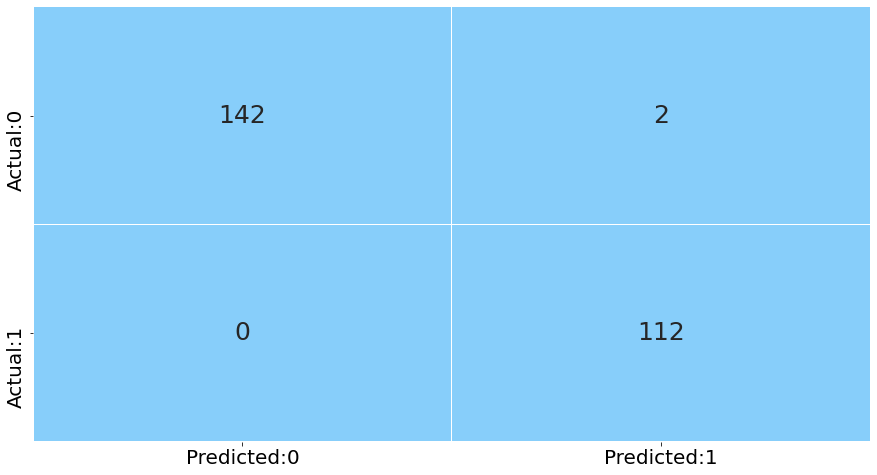

In [108]:
plot_confusion_matrix(xgb_model)

In [109]:
test_report = get_test_report(xgb_model)

print(test_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       144
           1       0.98      1.00      0.99       112

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



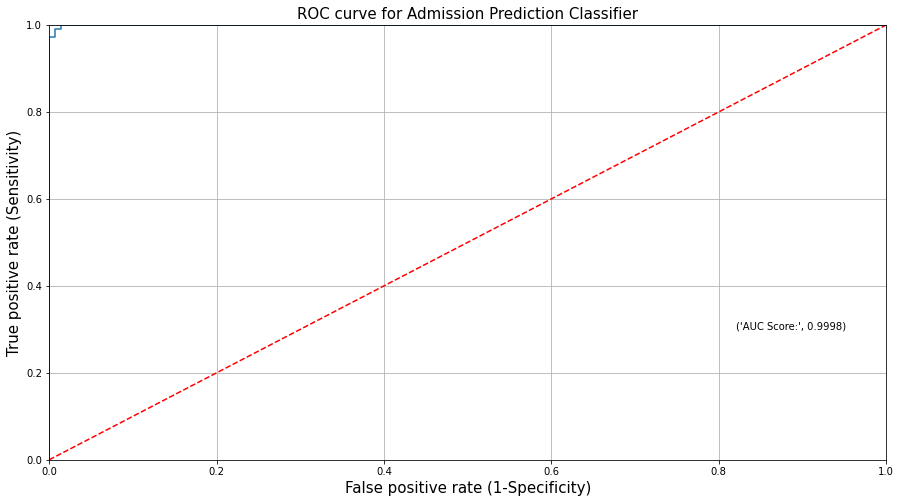

In [111]:
plot_roc(xgb_model)

<a id="stack"></a>
# Stack Generalization  

In [116]:
base_learners = [('rf_model', RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 'sqrt', 
                                                     max_leaf_nodes = 8, min_samples_leaf = 5, min_samples_split = 2, 
                                                     n_estimators = 50, random_state = 10)),
                 ('KNN_model', KNeighborsClassifier(n_neighbors = 17, metric = 'euclidean')),
                 ('NB_model', GaussianNB())]


stack_model = StackingClassifier(estimators = base_learners, final_estimator = GaussianNB())

stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf_model',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=8,
                                                       min_samples_leaf=5,
                                                       n_estimators=50,
                                                       random_state=10)),
                               ('KNN_model',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=17)),
                               ('NB_model', GaussianNB())],
                   final_estimator=GaussianNB())

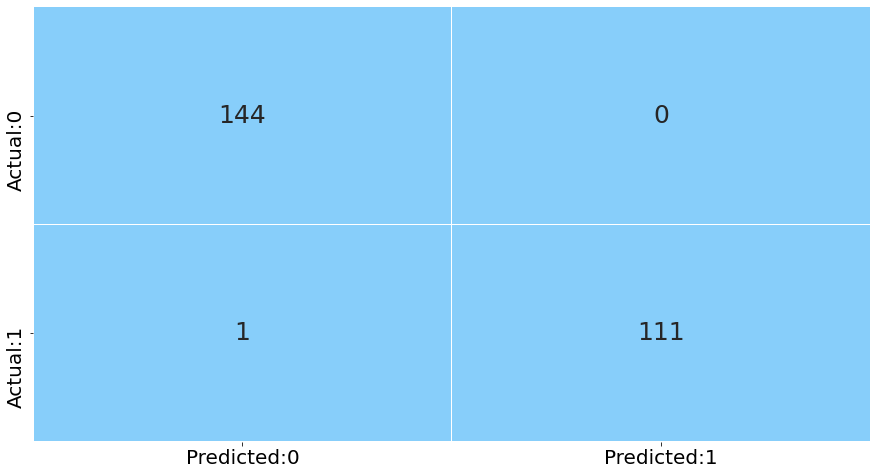

In [113]:
plot_confusion_matrix(stack_model)

In [114]:
test_report = get_test_report(stack_model)

print(test_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       144
           1       1.00      0.99      1.00       112

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



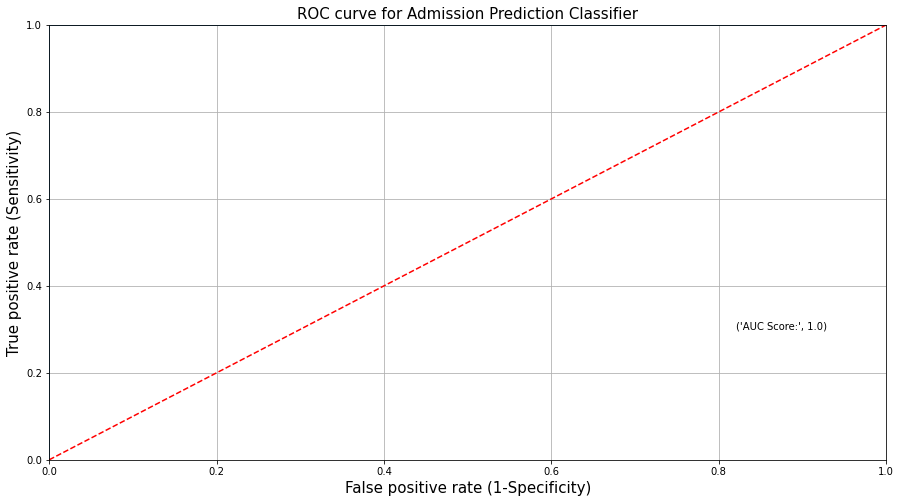

In [115]:
plot_roc(stack_model)

**CONCLUSION**

In [133]:
print("LogisticRegression: {0:.4f}%".format(accuracy.mean()*100))


LogisticRegression: 99.6094%


In [ ]:
just plot the table
